In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats
import pandas as pd
import networkx as nx
import itertools as it
import math
import random
from sklearn.metrics import r2_score

In [2]:
"""
Estimation Maximation class implementation
Jay Lobell
"""
class EM:
    def __init__(self, samples : int, nodes : int, theta : tuple) :
        self.samples = samples
        self.nodes = nodes
        #Unpack model parameters here
        self.slowrate, self.fastrate, self.rho = theta
    """
    Estimation Step function
    
    Parameters
    ---------
    X : np.array
        Population Network
        
    Returns
    -------
    Q : np.array
        Matrix of probabilities (i.e. connections between nodes)
    
    """
    def e_step(self, X : np.array) -> np.array:
        #Initialize matrix of probabilities
        self.Q = np.zeros((self.nodes, self.nodes))
        for i,j in it.combinations(range(self.nodes), 2):
            #Calculate rates from Poisson distributions
            h = (self.rho * math.pow(self.fastrate, X[i,j]) * math.exp(-self.fastrate)) / math.factorial(X[i,j])
            g = ((1 - self.rho) * math.pow(self.slowrate, X[i,j]) * math.exp(-self.slowrate)) / math.factorial(X[i,j])
            #set probabilities of matrix
            self.Q[i, j] = h / (h + g)
            self.Q[j, i] = self.Q[i, j]
        return self.Q
    """
    Maximation step function, updates parameters of model according to a global log liklihood value
    
    Parameters
    ----------
    X : np.array
        Population Network
        
    Returns
    ----------
    slowrate : float
        Rate of non kin interactions in Elephant network
    fastrate : float
        Rate of kin interactions in Elephant network
    rho : float
        Network density
    
    """
    def m_step(self, X : np.array) -> (float, float, float):
        #update class variables
        self.rho = np.sum(np.triu(self.Q,1)) / math.comb(self.nodes, 2) 
        self.slowrate = np.sum(np.triu(X * ( 1 - self.Q ), 1)) / np.sum(np.triu(( 1 - self.Q ), 1))
        self.fastrate = np.sum(np.triu(X * self.Q, 1)) / np.sum(np.triu(self.Q, 1))
        return self.slowrate, self.fastrate, self.rho
    
    """
    Algorithm driver function, optimizes parameters according to constraints
    
    Parameters
    ----------
    X : np.array
        Population Network
    
    Returns
    -------
    trajectory : np.array
        Stores model parameters and matrix of probabilites of node connections in an array
    
    """
    def em_algo(self, X : np.array) -> np.array:
        #parameters are not yet converged
        converged = False
        trajectory = []
        while converged == False:
            #store old parameter values
            oldslowrate = self.slowrate
            oldfastrate = self.fastrate
            oldrho = self.rho
            #Run algorithm
            self.e_step(X)
            self.m_step(X)
            trajectory.append({"Q" : self.Q, "slowrate" : self.slowrate, "fastrate" : self.fastrate, "rho" : self.rho})
            #Set constraints on rates of change of model parameters
            if abs(self.slowrate - oldslowrate) < .01 and abs(self.fastrate - oldfastrate) < .01 and abs(self.rho - oldrho) < .001:
                converged = True
        return trajectory
    """
    Generate Error model function
    
    Parameters
    ---------
    G : graph
        networkx representation of graph with nodes, edges, and edge weight parameters
        
    Returns
    -------
    sample : nx.Graph
        Randomly assigned connections in graphs result in a simulated representation of the network at hand.
    """
    def generate_error_model(self, G : nx.Graph) -> nx.Graph:
        n = G.number_of_nodes()
        sample = nx.Graph()
        for i, j in it.combinations(range(n), 2): 
            if G.has_edge(i, j):
                #Conditional clause,
                if G[i][j]['Number of contacts'] * 2 * np.random.rand() < self.fastrate and G[i][j]['Number of contacts'] * np.random.rand() < self.slowrate :
                    sample.add_weighted_edges_from([(i,j, np.random.poisson(self.slowrate))],"Number of contacts")
                else:        
                    sample.add_weighted_edges_from([(i,j, np.random.poisson(self.fastrate))],"Number of contacts")
            else:
                return
        return sample
        

In [3]:
df = pd.read_csv("tracking_logs.txt", delimiter=",")
G = nx.from_pandas_edgelist(df, 'Elephant A', 'Elephant B', ['Number of contacts']) 

In [5]:
nodes = 24
samples = 10
slowrate = 20
fastrate = 45
rho = 0.6
em = EM(samples, nodes, (slowrate, fastrate, rho)) 
x = [em.generate_error_model(G) for t in range(samples)]

In [6]:
X = np.zeros((nodes, nodes), dtype=int)
for i,j in it.combinations(range(nodes), 2):
    X[i, j] = np.sum([y[i][j]['Number of contacts'] for y in x]) / samples
    X[j, i] = X[i, j]

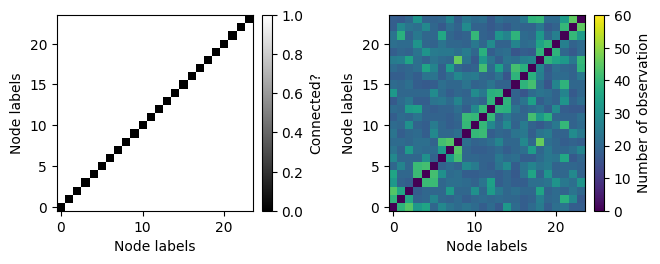

In [7]:
plt.figure(figsize=(10,3))
plt.subplot(132)
im=plt.imshow(nx.linalg.adjacency_matrix(G).todense(), origin='lower', cmap=plt.cm.gray);
plt.colorbar(im, label='Connected?', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

plt.subplot(133)
im = plt.imshow(X, origin='lower', vmin=0, vmax=60);
plt.colorbar(im, label='Number of observation', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

In [8]:
trajectory = em.em_algo(X)

In [9]:
Q = trajectory[0]
print(Q["slowrate"])
print(Q["fastrate"])
print(Q["rho"])

21.00852400451791
37.13264219911295
0.1826068570493183


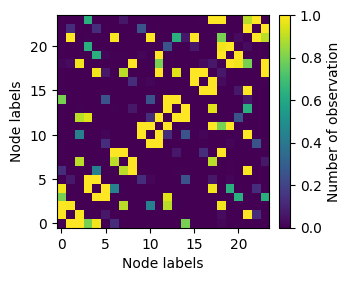

In [10]:
plt.figure(figsize=(10,3))
plt.subplot(133)
im = plt.imshow(Q["Q"], origin='lower', vmin=0, vmax=1);
plt.colorbar(im, label='Number of observation', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

In [11]:
newsamples = 100
newslowrate = Q["slowrate"]
newfastrate = Q["fastrate"]
newrho = Q["rho"]

In [12]:
new_em = EM(newsamples, nodes, (newslowrate, newfastrate, newrho))
newx = [new_em.generate_error_model(G) for t in range(newsamples)]

In [13]:
sampleQ = list()
sampleSlowrate = list()
sampleFastrate = list()
sampleRho = list()
for graph in newx: 
    array = nx.linalg.adjacency_matrix(graph, weight='Number of contacts').todense()
    trajectory = new_em.em_algo(array)
    sample = (trajectory[0])
    sampleQ.append(sample["Q"])
    sampleSlowrate.append(sample["slowrate"])
    sampleFastrate.append(sample["fastrate"])
    sampleRho.append(sample["rho"])
    
print(f'95 percent confidence inverval of average slowrate : {np.mean(sampleSlowrate)- 1.96 * np.std(sampleSlowrate)}, {np.mean(sampleSlowrate) + 1.96 * np.std(sampleSlowrate)}')
print(f'95 percent confidence inverval of average fastrate : {np.mean(sampleFastrate) - 1.96 * np.std(sampleFastrate)} , {np.mean(sampleFastrate) + 1.96 * np.std(sampleFastrate)}')
print(f'95 percent confidence inverval of average rho : {np.mean(sampleRho) - 1.96 * np.std(sampleRho)}, {np.mean(sampleRho) + 1.96 * np.std(sampleRho)}')

avg_node_probability_of_connection = np.mean(np.mean(sampleQ, axis = 0), axis = 0)
print(f'95 percent confidence inverval of average probability of a node being connected to any other node : \n{np.mean(avg_node_probability_of_connection) - 1.96 * np.std(avg_node_probability_of_connection)} , {np.mean(avg_node_probability_of_connection) + 1.96 * np.std(avg_node_probability_of_connection)}')


95 percent confidence inverval of average slowrate : 20.43235709549307, 21.610136171488104
95 percent confidence inverval of average fastrate : 35.33883110348204 , 38.74166253671647
95 percent confidence inverval of average rho : 0.17843415051706144, 0.2759227566563798
95 percent confidence inverval of average probability of a node being connected to any other node : 
0.1495740519169086 , 0.28585131745763925


In [14]:
arrays = list()
for x in range(len(newx)):
   array = nx.linalg.adjacency_matrix(newx[x], weight='Number of contacts').todense()
   arrays.append(array)

In [15]:
average_edge_weights = [np.mean(array) for array in arrays]
# Mean : print(np.mean(average_edge_weights))
# SD : print(np.std(average_edge_weights))
print(f'95 percent confidence interval of average edge weight in network : ({np.mean(average_edge_weights) - 1.96 * np.std(average_edge_weights)} , {np.mean(average_edge_weights) + 1.96 * np.std(average_edge_weights)})  ')

95 percent confidence interval of average edge weight in network : (22.918580461915177 , 24.336905649195934)  


In [16]:
average_std_of_network = [np.std(array) for array in arrays]
# Mean : print(np.mean(average_std_of_network))
# SD : print(np.std(average_std_of_network))
print(f'95 percent confidence interval of average SD of network : ({np.mean(average_std_of_network) - 1.96 * np.std(average_std_of_network)} , {np.mean(average_std_of_network) + 1.96 * np.std(average_std_of_network)})  ')

95 percent confidence interval of average SD of network : (8.918941690011563 , 10.139935051633854)  


In [17]:
average_eigenvalues = [float(np.mean(nx.adjacency_spectrum(graph, weight='Number of contacts'))) for graph in newx]
print(f'95 percent confidence interval of average eigenvalue of network : ({np.mean(average_eigenvalues) - 1.96 * np.std(average_eigenvalues)} , {np.mean(average_eigenvalues) + 1.96 * np.std(average_eigenvalues)}')

95 percent confidence interval of average eigenvalue of network : (-4.8707973075277387e-14 , 4.986260502088755e-14


/tmp/ipykernel_1057/2415700272.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  average_eigenvalues = [float(np.mean(nx.adjacency_spectrum(graph, weight='Number of contacts'))) for graph in newx]


(array([ 2.,  5.,  5., 17., 10., 22., 16., 10.,  9.,  4.]),
 array([22.71527778, 22.88402778, 23.05277778, 23.22152778, 23.39027778,
        23.55902778, 23.72777778, 23.89652778, 24.06527778, 24.23402778,
        24.40277778]),
 <BarContainer object of 10 artists>)

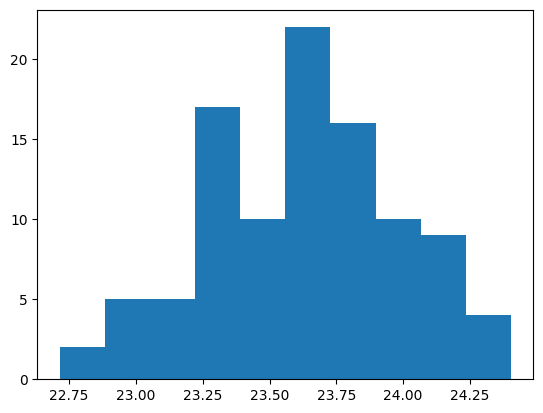

In [18]:
plt.hist(average_edge_weights)

(array([ 2.,  4.,  9., 10., 18., 16., 13., 10., 12.,  6.]),
 array([ 8.77380951,  8.91020798,  9.04660646,  9.18300493,  9.3194034 ,
         9.45580188,  9.59220035,  9.72859883,  9.8649973 , 10.00139577,
        10.13779425]),
 <BarContainer object of 10 artists>)

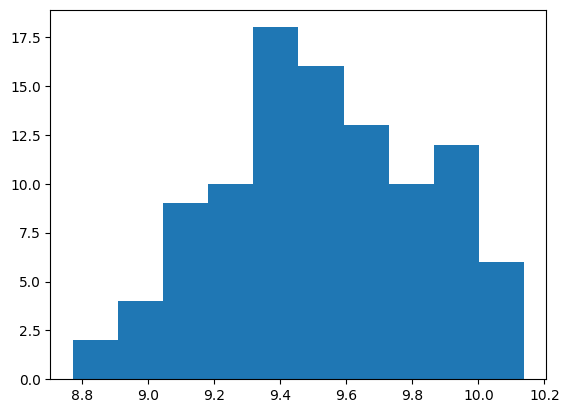

In [19]:
plt.hist(average_std_of_network)

(array([ 1.,  2.,  3.,  9., 16., 14., 16., 19.,  9., 11.]),
 array([-7.46069873e-14, -6.24093370e-14, -5.02116867e-14, -3.80140364e-14,
        -2.58163861e-14, -1.36187358e-14, -1.42108547e-15,  1.07765648e-14,
         2.29742151e-14,  3.51718654e-14,  4.73695157e-14]),
 <BarContainer object of 10 artists>)

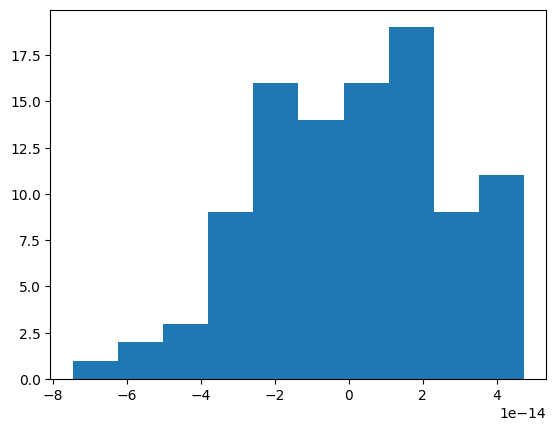

In [20]:
plt.hist(average_eigenvalues)

Average Standard Deviation of Array = 0.5224598842296888 * Average Edge Weight + -2.8151095305916756
R squared : 0.36832476882142473


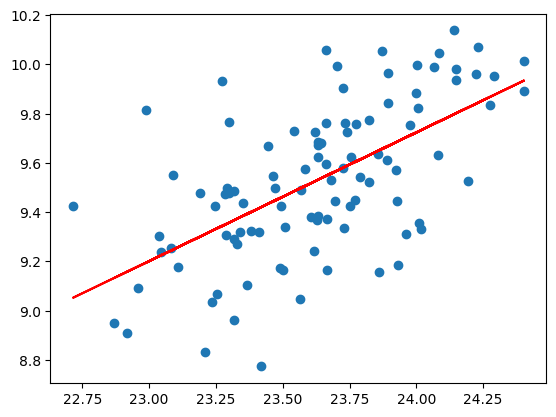

In [21]:
average_edge_weights = np.array(average_edge_weights)
average_std_of_network = np.array(average_std_of_network)
average_eigenvalues = np.array(average_eigenvalues)

slope, intercept = np.polyfit(average_edge_weights, average_std_of_network, 1)
plt.scatter(average_edge_weights, average_std_of_network)
plt.plot(average_edge_weights, slope * average_edge_weights + intercept , color='red')

model = np.polyfit(average_edge_weights, average_std_of_network, 1)
predict = np.poly1d(model)
r2 = r2_score(average_std_of_network, predict(average_edge_weights))
print(f'Average Standard Deviation of Array = {slope} * Average Edge Weight + {intercept}')
print(f'R squared : {r2}')


Average Standard Deviation of network = 3.966297184857959e-15 * Average Eigenvalue + -3.721926861066644e-14
R squared : 0.002413806773686855


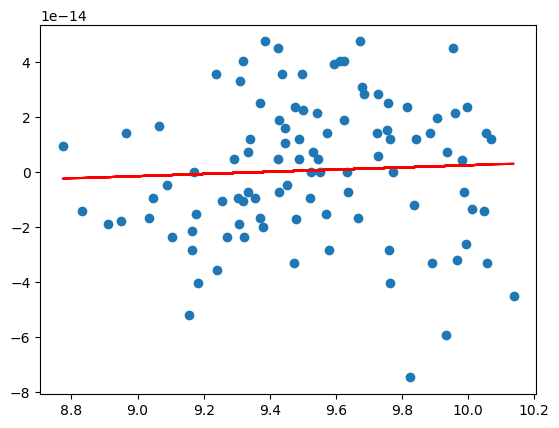

In [22]:
slope, intercept = np.polyfit(average_std_of_network, average_eigenvalues, 1)
plt.scatter(average_std_of_network, average_eigenvalues )
plt.plot(average_std_of_network, slope * average_std_of_network + intercept , color='red')

model = np.polyfit(average_std_of_network, average_eigenvalues, 1)
predict = np.poly1d(model)
r2 = r2_score(average_eigenvalues, predict(average_std_of_network))
print(f'Average Standard Deviation of network = {slope} * Average Eigenvalue + {intercept}')
print(f'R squared : {r2}')

Average Standard Deviation of Array = -3.2924713168658578e-15 * Average Edge Weight + 7.837098226549818e-14
R squared : 0.002244403947620932


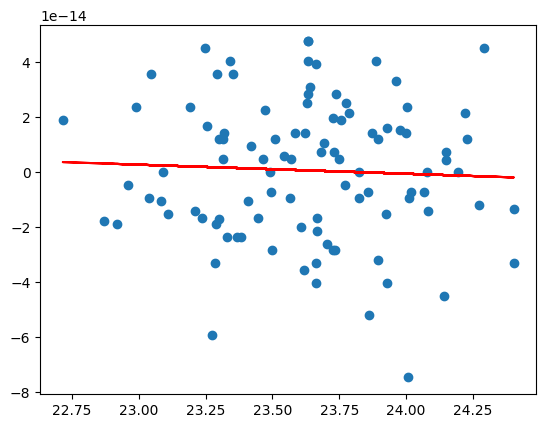

In [23]:
slope, intercept = np.polyfit(average_edge_weights, average_eigenvalues, 1)
plt.scatter(average_edge_weights, average_eigenvalues)
plt.plot(average_edge_weights, slope * average_edge_weights + intercept , color='red')

model = np.polyfit(average_edge_weights, average_eigenvalues, 1)
predict = np.poly1d(model)
r2 = r2_score(average_eigenvalues, predict(average_edge_weights))
print(f'Average Standard Deviation of Array = {slope} * Average Edge Weight + {intercept}')
print(f'R squared : {r2}')

In [85]:
g = nx.read_adjlist('marvel_adj.txt', nodetype=int , delimiter=' ')
random_node_sampling_list = list()
random_edge_sampling_list = list()

In [30]:
#Random Node Sampling
for i in range(100):    
    n = [x for x in g.nodes() if np.random.rand() < .01]
    n = g.subgraph(n)
    random_node_sampling_list.append(n)

In [31]:
#Random Edge Sampling
for i in range(100):    
    e = [y for y in g.edges() if np.random.rand() < .001]
    e = g.edge_subgraph(e)
    random_edge_sampling_list.append(e)

In [ ]:
h = nx.linalg.adjacency_matrix(g).todense()
generations = 5
random_seeds = 5
i = 0
l = [np.random.randint(16959) for x in range(random_seeds)]
while i < random_seeds:
    for m in l:
        l.append(np.nonzero(h[m]))
    i = i + 1